In [1]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.artifacts.animation_artifact import AnimationArtifact

torch.set_grad_enabled(False)   

n_frames = 5
animation = AnimationArtifact.from_wandb_artifact_tag('rumba:latest')
cams, frames = animation.cams_and_frames(n_frames)
uv_verts, uv_faces = animation.texture_data()

In [2]:
# load pipeline
from diffusers.models import ControlNetModel
from diffusers.schedulers import DPMSolverMultistepScheduler
import torch

from text3d2video.generative_rendering.configs import GenerativeRenderingConfig
from text3d2video.generative_rendering.generative_rendering_pipeline import (
    GenerativeRenderingPipeline,
)

device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

controlnet = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype).to(
    device
)

pipe: GenerativeRenderingPipeline = GenerativeRenderingPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


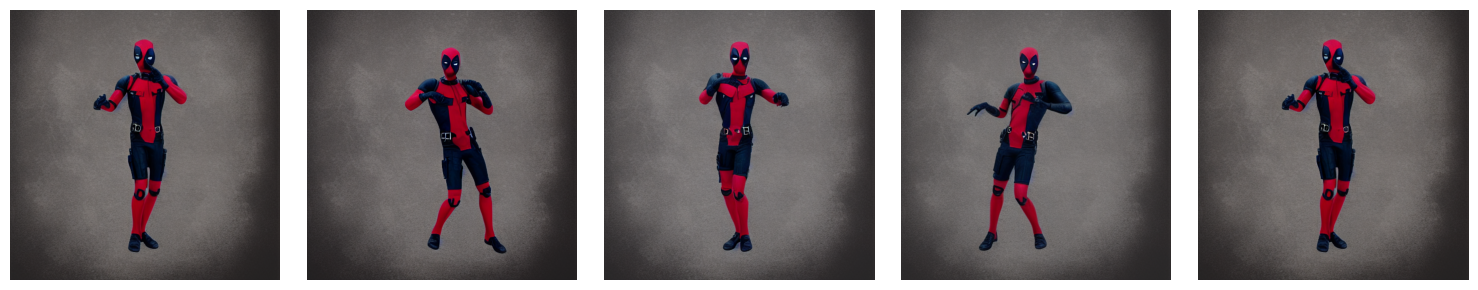

In [3]:
from text3d2video.generative_rendering.configs import (
    GrSaveConfig,
    NoiseInitializationConfig,
    NoiseInitializationMethod,
)
from text3d2video.ipython_utils import display_ims

module_paths = [
    "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

gr_config = GenerativeRenderingConfig(
    seed=0,
    resolution=512,
    do_pre_attn_injection=True,
    do_post_attn_injection=False,
    feature_blend_alpha=0.5,
    attend_to_self_kv=False,
    mean_features_weight=0.5,
    chunk_size=5,
    num_keyframes=4,
    num_inference_steps=10,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

save_config = GrSaveConfig(
    enabled=True,
    save_latents=True,
    save_q=True,
    save_k=True,
    save_v=True,
    save_features=False,
    save_features_3d=True,
    n_frames=3,
    n_timesteps=5,
    out_artifact="gr_data",
    module_paths=module_paths,
)

noise_config = NoiseInitializationConfig(
    method=NoiseInitializationMethod.UV,
)
noise_config.uv_texture_res = 64

prompt = "Deadpool Dancing"

video_frames = pipe(
    prompt,
    frames,
    cams,
    uv_verts,
    uv_faces,
    generative_rendering_config=gr_config,
    noise_initialization_config=noise_config,
    gr_save_config=save_config,
)

art = pipe.gr_data_artifact

display_ims(video_frames, scale=3)

In [4]:
# Artifact datasets
print(art.folder)
art.print_datasets()

/tmp/tmp5amgzge8
frame_indices (3,)
time_0/frame_0/latents (4, 64, 64)
time_0/frame_2/latents (4, 64, 64)
time_0/frame_4/latents (4, 64, 64)
time_999/frame_0/latents (4, 64, 64)
time_999/frame_0/layer_down_blocks.0.attentions.0.transformer_blocks.0.attn1/attn_out_post (320, 64, 64)
time_999/frame_0/layer_down_blocks.0.attentions.0.transformer_blocks.0.attn1/attn_out_pre (320, 64, 64)
time_999/frame_0/layer_down_blocks.0.attentions.0.transformer_blocks.0.attn1/key (16384, 320)
time_999/frame_0/layer_down_blocks.0.attentions.0.transformer_blocks.0.attn1/query (4096, 320)
time_999/frame_0/layer_down_blocks.0.attentions.0.transformer_blocks.0.attn1/value (16384, 320)
time_999/frame_0/layer_down_blocks.0.attentions.1.transformer_blocks.0.attn1/attn_out_post (320, 64, 64)
time_999/frame_0/layer_down_blocks.0.attentions.1.transformer_blocks.0.attn1/attn_out_pre (320, 64, 64)
time_999/frame_0/layer_down_blocks.0.attentions.1.transformer_blocks.0.attn1/key (16384, 320)
time_999/frame_0/layer_do

In [9]:
timesteps = art.read_timesteps()
frame_indices = art.read_frame_indices()
module_paths = art.read_module_paths()

In [10]:
from text3d2video.sd_feature_extraction import AttnLayerId, BlockType

# read layers
layers = [AttnLayerId.parse_module_path(m) for m in module_paths]
up_layers = [l for l in layers if l.block_type == BlockType.UP]
down_layers = [l for l in layers if l.block_type == BlockType.DOWN]

up_layers = sorted(up_layers, key=lambda l: l.unet_absolute_index())
down_layers = sorted(down_layers, key=lambda l: l.unet_absolute_index())

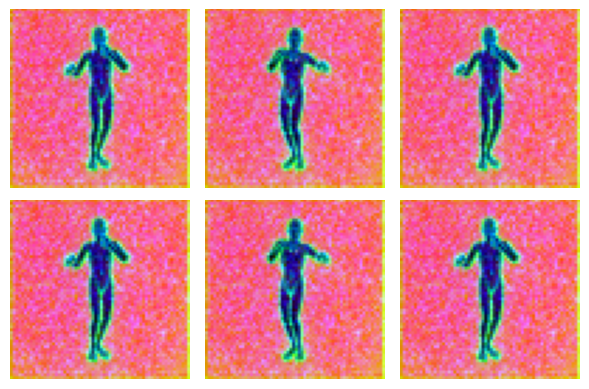

In [11]:
from einops import rearrange

from text3d2video.feature_visualization import RgbPcaUtil
from text3d2video.ipython_utils import display_ims_grid

module = up_layers[-1].module_path()
timestep = timesteps[0]

features_pre = [art.read_feature(timestep, frame, module, 'attn_out_pre') for frame in frame_indices]
features_post = [art.read_feature(timestep, frame, module, 'attn_out_post') for frame in frame_indices]

features_pre = torch.stack(features_pre)
features_post = torch.stack(features_post)

features_flat = rearrange(features_pre, 'b c h w -> (b h w) c')
pca_key = RgbPcaUtil.init_from_features(features_flat)

features_pre_rgb = [pca_key.feature_map_to_rgb_pil(f) for f in features_pre]
features_post_rgb = [pca_key.feature_map_to_rgb_pil(f) for f in features_post]

display_ims_grid([features_pre_rgb, features_post_rgb], scale=2)

In [25]:
from matplotlib import pyplot as plt
from text3d2video.attention_visualization import reshape_concatenated

attn_layer = up_layers[-1]

module = attn_layer.module_path()
frame_idx = frame_indices[0]
timestep = timesteps[1]

layer_res = attn_layer.layer_resolution(pipe.unet)
keys = art.read_feature(timestep, frame_idx, module, 'key')

pca_key = RgbPcaUtil.init_from_features(keys)
keys_square = reshape_concatenated(keys, layer_res)
keys_square_rgb = pca_key.feature_map_to_rgb_pil(keys_square)

plt.imshow(keys_square_rgb)

ValueError: Dataset time_749/frame_0/layer_up_blocks.3.attentions.2.transformer_blocks.0.attn1/key not found in h5 file